In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [12]:
test = pd.read_csv('https://raw.githubusercontent.com/EsmaeilNourani/Deep-GDAE/master/data/our_corpus/test_samples20of100.csv', sep=',')
train  = pd.read_csv('https://raw.githubusercontent.com/EsmaeilNourani/Deep-GDAE/master/data/our_corpus/train_samples_50of100.csv', sep=',')
val = pd.read_csv('https://raw.githubusercontent.com/EsmaeilNourani/Deep-GDAE/master/data/our_corpus/val_samples_30of100.csv', sep=',')

In [14]:
train=train[['raw_sentence', 'associationType']]
test=test[['raw_sentence', 'associationType']]
val=val[['raw_sentence', 'associationType']]

In [15]:
train.columns=['comment', 'recom']
test.columns=['comment', 'recom']
val.columns=['comment', 'recom']

In [16]:
train.head()

,comment,recom
0,We now have evidence that the complete human c...,Biomarker
1,We also show that several risk loci are common...,Biomarker
2,UNASSIGNED: 10006 Background: Dasatinib is an ...,Negative
3,It also significantly restored hippocampal lev...,Negative
4,"Finally, the induction of MMP-2 and MMP-9 by c...",Negative


In [17]:
train.dropna(subset=['recom', 'comment'], inplace=True, how="any")
test.dropna(subset=['recom', 'comment'], inplace=True, how="any")
val.dropna(subset=['recom', 'comment'], inplace=True, how="any")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [18]:
possible_labels = train.recom.unique()
possible_labels

array(['Biomarker', 'Negative', 'Therapeutic'], dtype=object)

In [19]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Biomarker': 0, 'Negative': 1, 'Therapeutic': 2}

In [20]:
train['label'] = train.recom.replace(label_dict)
test['label']  = test.recom.replace(label_dict)
val['label']  = val.recom.replace(label_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
pip install transformers

     |████████████████████████████████| 4.0 MB 5.7 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 31.9 MB/s 
     |████████████████████████████████| 596 kB 31.3 MB/s 
     |████████████████████████████████| 6.5 MB 35.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


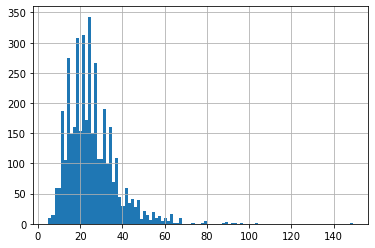

In [22]:
train['len'] = train.comment.str.split().str.len()
train['len'].hist(bins=100)

In [23]:
max_length=60

In [24]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [25]:
#bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
                                          do_lower_case=False)

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [26]:
encoded_data_train = tokenizer.batch_encode_plus(
    train.comment.values,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val.comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test.comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val.label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test.label.values)

In [28]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [29]:
from transformers import BertForSequenceClassification

In [30]:
model = BertForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [46]:
batch_size = 16
epochs = 10

In [33]:
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

In [34]:
dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [35]:
dataloader_test = DataLoader(dataset_test, 
                             sampler=SequentialSampler(dataset_test), 
                             batch_size=batch_size)

In [36]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [37]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [38]:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score

In [40]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print('accuracy : ', accuracy_score(labels_flat, preds_flat))
    print('precision : ', precision_score(labels_flat, preds_flat, average='weighted'))
    print('recall : ', recall_score(labels_flat, preds_flat, average='weighted'))
    print('f1 : ', f1_score(labels_flat, preds_flat, average='weighted'))

    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [41]:
import random

In [42]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [43]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model.to(device)

There are 1 GPU(s) available.
Device name: Tesla K80


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [44]:
def evaluate(dataloader_val):

    # deactivate dropout layers
    model.eval()
    
    loss_val_total = 0

    # empty list to save the model predictions
    predictions, true_vals = [], []
    
    # iterate over batches
    for batch in dataloader_val:
        
        # push the batch to gpu
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        # deactivate autograd
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        # model predictions are stored on GPU. So, push it to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        predictions.append(logits)
        true_vals.append(label_ids)
    
    # compute the validation loss of the epoch
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    # reshape the predictions in form of (number of samples, no. of classes)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [47]:
for epoch in tqdm(range(1, epochs+1)):
    
    #initialize parameters and start trianing process 
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False, disable=False)
    
    for batch in progress_bar:

        # clear previously calculated gradients 
        model.zero_grad()

        # push the batch to gpu
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters (weights) and the learning rate
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
#     torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5730117719769477
accuracy :  0.8104166666666667
precision :  0.8057920346008289
recall :  0.8104166666666667
f1 :  0.7983171097687662
Validation loss: 0.47595347022016843
F1 Score (Weighted): 0.7983171097687662


Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3948593881726265
accuracy :  0.8375
precision :  0.8283825108560445
recall :  0.8375
f1 :  0.8304824739628214
Validation loss: 0.41302400827407837
F1 Score (Weighted): 0.8304824739628214


Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.30493025094270704
accuracy :  0.83375
precision :  0.8323178283300741
recall :  0.83375
f1 :  0.8277797186268238
Validation loss: 0.43868226076165834
F1 Score (Weighted): 0.8277797186268238


Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.24727989915758372
accuracy :  0.8416666666666667
precision :  0.8411039066260891
recall :  0.8416666666666667
f1 :  0.8386640579062828
Validation loss: 0.4502401571472486
F1 Score (Weighted): 0.8386640579062828


Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.20367159216850997
accuracy :  0.8479166666666667
precision :  0.8453660556687703
recall :  0.8479166666666667
f1 :  0.8435363737137479
Validation loss: 0.4587765360871951
F1 Score (Weighted): 0.8435363737137479


Epoch 6:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.19410318727046252
accuracy :  0.8479166666666667
precision :  0.8453660556687703
recall :  0.8479166666666667
f1 :  0.8435363737137479
Validation loss: 0.4587765360871951
F1 Score (Weighted): 0.8435363737137479


Epoch 7:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.19434772498905659
accuracy :  0.8479166666666667
precision :  0.8453660556687703
recall :  0.8479166666666667
f1 :  0.8435363737137479
Validation loss: 0.4587765360871951
F1 Score (Weighted): 0.8435363737137479


Epoch 8:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.19435056629776953
accuracy :  0.8479166666666667
precision :  0.8453660556687703
recall :  0.8479166666666667
f1 :  0.8435363737137479
Validation loss: 0.4587765360871951
F1 Score (Weighted): 0.8435363737137479


Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [50]:
#load weights of best model
# model.load_state_dict(torch.load('finetuned_BERT_epoch_7.model'))

In [49]:
# get predictions for test data
_, predictions, true_vals = evaluate(dataloader_test)

In [51]:
from sklearn.metrics import classification_report
y_pred_bool = np.argmax(predictions, axis=1)

In [52]:
print(classification_report(true_vals, y_pred_bool, digits=4))

              precision    recall  f1-score   support

           0     0.7908    0.8856    0.8355       717
           1     0.9051    0.8462    0.8747       800
           2     0.3878    0.2289    0.2879        83

    accuracy                         0.8319      1600
   macro avg     0.6945    0.6536    0.6660      1600
weighted avg     0.8270    0.8319    0.8267      1600

